# Algoritmo Naive Bayes

In [1]:
import os, sys
import pandas as pd
import matplotlib.pyplot as plt

from spacy.lang.pt import Portuguese

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

#### Importing helper

In [2]:
# Importing custom functions (temp)
current_dir = os.path.abspath('')
parent_dir = os.path.dirname(current_dir)
parent_dir = os.path.dirname(parent_dir)
sys.path.append(parent_dir)

from helpers.string_cleaner import StringCleaner as sc

### 1. Processamento Dataset

#### 1.1 Extrair dataset

In [3]:
true_ds = pd.read_csv('datasets/base/true.csv')
fake_ds = pd.read_csv('datasets/base/fake.csv')

In [4]:
true_ds['target'] = "true"
fake_ds['target'] = "fake"

In [5]:
fake_df = pd.DataFrame(fake_ds)
true_df = pd.DataFrame(true_ds)

df = pd.concat([fake_df, true_ds])
# pd.set_option('display.max_colwidth', None)

#### 1.2 Limpar o dataframe

**Observações**:
* Verificar a necessidade de adicionar as siglas dos estados brasileiros como stop words.
* Verificar a necessidade de remover o conteúdo entre colchetes e parênteses.
* Verificar a necessidade de remover formatação de datas e horários
* Verificar a necessidade de remover caracteres especiais, como: cedilha, acentos, etc.

In [6]:
# stop words using spaCy
nlp_pt = Portuguese()
stopwords = nlp_pt.Defaults.stop_words
# nlp_pt.Defaults.stop_words.remove('sem')
# nlp_pt.Defaults.stop_words.add('to')

def remove_stopwords(text):
    final_text = []
    for token in text.split():
      if token.lower() not in stopwords:
          final_text.append(token)
    return " ".join(final_text)

def denoise_text(text):
    text = sc.remove_url(text)
    text = sc.remove_special_characters(text)
    text = remove_stopwords(text)

    return text.lower()

df['full_text'] = df['full_text'].apply(denoise_text)

### 2. Aplicar Naive Bayes

#### 2.1 Dividindo o dataset e transformando em um array vetorizado

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df['full_text'],
    df['target'],
    random_state=0,
    test_size=.3
)

In [8]:
vectorizer = CountVectorizer(ngram_range=(1,1)).fit(X_train)

In [9]:
X_train_vectorized = vectorizer.fit_transform(X_train)

#### 2.2 Criando um modelo de Naive Bayes e o treinando com o dataset

In [10]:
model = MultinomialNB(alpha=0.1)
model.fit(X_train_vectorized, Y_train)

MultinomialNB(alpha=0.1)

#### 2.3 Realizando uma predição

In [11]:
Y_predict = model.predict(vectorizer.transform(X_test))

#### 2.5 Observando a precisão

In [12]:
accuracy = accuracy_score(Y_test, Y_predict)*100
print(str(accuracy) + " %")

84.53703703703704 %


#### 2.6 Métricas mais detalhadas

In [13]:
report = classification_report(Y_test, Y_predict, digits=7)
print(report)

              precision    recall  f1-score   support

        fake  0.9402110 0.7391705 0.8276574      1085
        true  0.7834736 0.9525581 0.8597817      1075

    accuracy                      0.8453704      2160
   macro avg  0.8618423 0.8458643 0.8437195      2160
weighted avg  0.8622051 0.8453704 0.8436452      2160



#### 2.4 Executando uma matrix de confusão

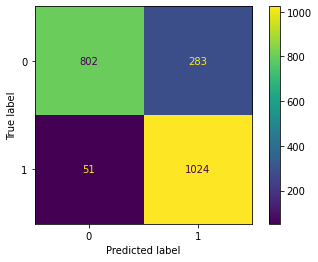

In [14]:
cm = confusion_matrix(Y_test, Y_predict, labels=["fake", "true"])
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot()
plt.show()